#Imports

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn import metrics
from nltk.stem.porter import *
from collections import Counter
from collections import defaultdict
from math import log
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Preprocessing

In [2]:
df = pd.read_csv("sentiment140.csv",encoding = "latin",header=None)

#Extract only columns with sentiments and tweets
tweets = df.iloc[:, [0, -1]].rename(columns={0: 'sentiment', 5: 'tweet'})
#tweets = tweets.sample(frac=0.1)

In [3]:
# define a function to stem a list of words
stemmer = PorterStemmer()
def stem_words(words):
    return [stemmer.stem(word) for word in words]

# define a function to preprocess the text
def preprocess_text(text):
    # Remove user mentions
    pattern = r'@[^\s]+'
    text = re.sub(pattern, '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # remove punctuation
    text = text.replace("[^a-zA-Z#]", " ")
    # convert to lowercase
    text = text.lower()
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]

    # stem each word in the list
    stemmed_words = [stemmer.stem(word) for word in tokens]

    # join the tokens back into a string
    text = ' '.join(stemmed_words)
    return text

# apply the preprocessing function to the 'tweet' column of the dataframe
tweets['tweet'] = tweets['tweet'].apply(preprocess_text)

In [4]:
tweets.head(100)

#tweets.to_csv('sentiment140_proc.csv', index=False)

Split into training and test set

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(tweets['tweet'], tweets['sentiment'], test_size = 0.2, random_state = 42)


# Developing a multinomial naive bayes model

In [7]:
class Multi_NB(): 

  def __init__(self): 
    self.priors = []
    self.theta_neg = []
    self.theta_pos = []




  def create_vocabulary(self, listy):
    words = listy.str.split().tolist()
    vocabulary = set([word for sublist in words for word in sublist])
    return vocabulary

  def caluculate_prior(self, lables): 
    neg, pos = Y_train.value_counts() #number of negative tweets, number of positive tweets
    total_tweets = len(Y_train)
    prior = [neg/total_tweets, pos/total_tweets]
    return prior

  def get_pos_and_neg(self,X_train, Y_train):
    pos_tweets = []
    neg_tweets = []
    for i in range(len(Y_train)):
      if Y_train.iloc[i]==0:
        neg_tweets.append(X_train.iloc[i])
      else:
        pos_tweets.append(X_train.iloc[i])
    return  neg_tweets, pos_tweets
  
  def get_num_words(self,list): 
    # Join all strings into one long string
    all_strings = ' '.join(list)

    # Split the long string into words
    all_words = all_strings.split()

    # Count the number of words
    return len(all_words)
  
  def calculate_cond_prob(self, vocabulary, sentences): 
    
    total_nr_words = self.get_num_words(sentences)
    
    # Create a defaultdict to store the frequency of each word in the vocabulary
    word_count = defaultdict(int)

    # Iterate through each string in the list of strings
    for sentence in sentences:
        # Split the string into individual words
        words = sentence.split()
        # Iterate through each word in the list of words
        for word in words:
            # If the word is in the vocabulary, increment its count in the defaultdict
            if word in vocabulary:
                word_count[word] += 1

    # Create a dictionary that maps each word in the vocabulary to its count
    counts = {word: (word_count[word]+1)/total_nr_words for word in vocabulary}

    return counts

  
  
  def fit(self, X_train, Y_train):
    
    # Create vocabulary from the given texts
    vocabulary = self.create_vocabulary(X_train)

    # Calculate he priors P(y)
    self.priors = self.caluculate_prior(Y_train)

    # Dividing sentences to pos and neg
    neg_tweets, pos_tweets = self.get_pos_and_neg(X_train, Y_train)
    
    # Calculate conditional probabilities P(x_i|y) for both labels 
    self.theta_neg = self.calculate_cond_prob(vocabulary, neg_tweets)
    self.theta_pos = self.calculate_cond_prob(vocabulary, pos_tweets)
  
  def predict(self, X_test): 
    y_pred = []
    for tweet in X_test:
        # Calculate log probabilities for each label
        neg_prob = log(self.priors[0])
        pos_prob = log(self.priors[1])
        for word in tweet.split():
            if word in self.theta_neg:
                neg_prob += log(self.theta_neg[word])
            if word in self.theta_pos:
                pos_prob += log(self.theta_pos[word])
        # Choose the label with the highest probability
        if pos_prob > neg_prob:
            y_pred.append(4)
        else:
            y_pred.append(0)
    return y_pred

  def score(self, X_test, Y_test):
      # Get predicted labels using predict method
      y_pred = self.predict(X_test)

      # Calculate evaluation metrics
      accuracy = accuracy_score(Y_test, y_pred)
      precision = precision_score(Y_test, y_pred, average='macro')
      recall = recall_score(Y_test, y_pred, average='macro')
      f1 = f1_score(Y_test, y_pred, average='macro')

      return accuracy, precision, recall, f1









In [20]:
M = Multi_NB()
M.fit(X_train, Y_train)

prediction_train = M.predict(X_train)
train_accuracy, train_precision, train_recall, train_f1 = M.score(X_train, Y_train)
print("training_accuracy: ", train_accuracy, "training_precision: ", train_precision, "training_recall: ", train_recall, "training_f1: ", train_f1)

prediction = M.predict(X_test)
accuracy, precision, recall, f1 = M.score(X_test, Y_test)
print("Accuracy: ", accuracy, "Precision: ", precision, "recall: ", recall, "f1: ", f1)

#k-fold cross validation

training_accuracy:  0.79240859375 training_precision:  0.7928013878144033 training_recall:  0.7923940282773374 training_f1:  0.7923332371437968
Accuracy:  0.765390625 Precision:  0.7658432092855156 recall:  0.7654539900303825 f1:  0.7653178007094428


In [51]:
print(Y_test.to_numpy(), prediction)
print(len(Y_test))

unique, counts = np.unique(Y_test.to_numpy(), return_counts=True)

dict(zip(unique, counts))

[0 0 0 ... 4 4 0] [4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 0, 4, 4, 0, 4, 4, 0, 0, 4, 4, 4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 4, 0, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 4, 4, 0, 0, 4, 0, 0, 4, 0, 4, 4, 0, 4, 0, 4, 4, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 0, 0, 4, 4, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 

{0: 159494, 4: 160506}

Confusion matrix

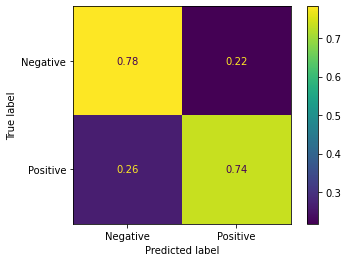

In [62]:
confusion_matrix = metrics.confusion_matrix(Y_test.to_numpy(), prediction)
normalized_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix, display_labels=["Negative", "Positive"])
cm_display.plot()
cm_display.figure_.savefig('conf_mat_tweets.png',dpi=300)


K-fold cross validation

In [67]:
from sklearn.model_selection import KFold
num_folds = 10
test_sizes = np.linspace(0.1, 0.9, num_folds-1)
accuracies = []
M = Multi_NB()

kf = KFold(n_splits=num_folds-1, shuffle=True, random_state=42)
for train_index, test_index in kf.split(tweets['tweet']):
    X_train, X_test = tweets['tweet'][train_index], tweets['tweet'][test_index]
    Y_train, Y_test = tweets['sentiment'][train_index], tweets['sentiment'][test_index]
    M.fit(X_train, Y_train)
    prediction = M.predict(X_test)
    accuracy, precision, recall, f1 = M.score(X_test, Y_test)
    accuracies.append(accuracy)
    
print(accuracies)
print("Average accuracy: ", np.average(accuracies))


[0.7659102926121343, 0.7644590444261945, 0.7667990415011982, 0.7642621696722879, 0.7647909190113512, 0.7636209204738494, 0.7641159198551002, 0.7668933551584288, 0.7646883455115117]
Average accuracy:  0.7650600009135617


In [68]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
clf = MultinomialNB()
clf.fit(X, Y_train)
X_tes = vectorizer.transform(X_test)
y_pred = clf.predict(X_tes)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.7642889687642384
